In [31]:
import pandas as pd
import pymysql
import matplotlib.pyplot as plt
import numpy as np
import warnings
import requests

In [32]:
warnings.filterwarnings('ignore')

In [33]:
# function to connect to wiki_dbs and query
def connect_and_query(wiki_name, query, cnf_path = "/home/paws/.my.cnf"):
    
    conn = pymysql.connect(host = wiki_name + '.analytics.db.svc.wikimedia.cloud',
                           read_default_file = cnf_path,
                           database = wiki_name + '_p')
    
    with conn.cursor() as cur:
        cur.execute(query)
        data = cur.fetchall()
    
    conn.close()
    return data

In [34]:
wikis = ['tewiki', 'hiwiki', 'mlwiki']
all_dfs = []

**Proportion of new users activated (last 30 days)**

In [31]:
query_url = "https://raw.githubusercontent.com/Mohan1503/community-insights-dashboard-tooling/main/Proportion of new users activated (last 30 days).sql"
query1 = requests.get(query_url).text

🔄 Querying tewiki...
🔄 Querying mlwiki...
📊 Activation Table:


,wiki,total_new_users,new_users_with_1_edit,new_users_with_5_edits,activation_rate_1_edit_percent
0,tewiki,396,28,4,7.07
1,mlwiki,588,67,9,11.39


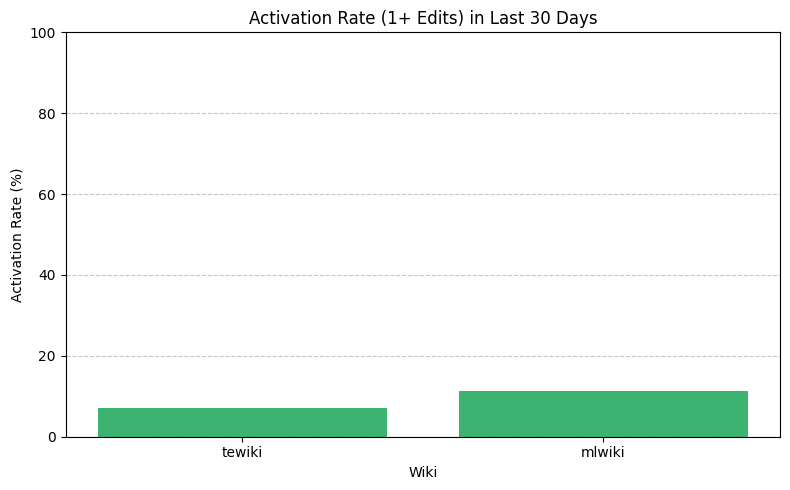

In [1]:
import pandas as pd
import pymysql
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Function to connect and run SQL query
def connect_and_query(wiki_name, query, cnf_path="/home/paws/.my.cnf"):
    try:
        conn = pymysql.connect(
            host=f"{wiki_name}.analytics.db.svc.wikimedia.cloud",
            read_default_file=cnf_path,
            database=f"{wiki_name}_p"
        )
        with conn.cursor() as cur:
            cur.execute(query)
            data = cur.fetchall()
        conn.close()
        return data
    except Exception as e:
        print(f"❌ Error querying {wiki_name}: {e}")
        return []

# Your query: overall activation metrics for last 30 days
query = """
WITH new_user_edit_counts AS (
    SELECT 
        u.user_id,
        u.user_registration,
        COALESCE(COUNT(r.rev_id), 0) AS edit_count
    FROM user u
    LEFT JOIN actor a ON u.user_id = a.actor_user
    LEFT JOIN revision r ON a.actor_id = r.rev_actor
    WHERE u.user_registration >= NOW() - INTERVAL 30 DAY
    GROUP BY u.user_id, u.user_registration
)
SELECT 
    COUNT(*) AS total_new_users,
    SUM(CASE WHEN edit_count >= 1 THEN 1 ELSE 0 END) AS new_users_with_1_edit,
    SUM(CASE WHEN edit_count >= 5 THEN 1 ELSE 0 END) AS new_users_with_5_edits,
    ROUND(
        (SUM(CASE WHEN edit_count >= 1 THEN 1 ELSE 0 END) * 100.0) / COUNT(*), 
        2
    ) AS activation_rate_1_edit_percent
FROM new_user_edit_counts;
"""

# Wikis to analyze
wikis = ['tewiki',  'mlwiki']
results = []

# Run query for each wiki
for wiki in wikis:
    print(f"🔄 Querying {wiki}...")
    output = connect_and_query(wiki, query)
    if output:
        row = list(output[0])
        row.insert(0, wiki)  # add wiki name
        results.append(row)
    else:
        print(f"⚠️ No data from {wiki}")

# Convert to DataFrame
if results:
    df = pd.DataFrame(results, columns=[
        'wiki',
        'total_new_users',
        'new_users_with_1_edit',
        'new_users_with_5_edits',
        'activation_rate_1_edit_percent'
    ])
    print("📊 Activation Table:")
    display(df)

    # Plot bar chart of activation rate
    plt.figure(figsize=(8, 5))
    plt.bar(df['wiki'], df['activation_rate_1_edit_percent'], color='mediumseagreen')
    plt.title('Activation Rate (1+ Edits) in Last 30 Days')
    plt.xlabel('Wiki')
    plt.ylabel('Activation Rate (%)')
    plt.ylim(0, 100)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("❌ No data to show.")


**top edited content pages for the selected time range**

In [37]:
query = """
SELECT 
    DATE(r.rev_timestamp) AS edit_date,
    p.page_id, 
    p.page_title, 
    COUNT(DISTINCT r.rev_id) AS edit_count
FROM revision r
JOIN page p ON r.rev_page = p.page_id
WHERE p.page_namespace = 0
GROUP BY DATE(r.rev_timestamp), p.page_id, p.page_title
ORDER BY edit_count DESC, edit_date DESC
LIMIT 10;
"""

In [38]:
def run_query_for_wikis(wikis, query):
    results = []
    for wiki in wikis:
        print(f"Querying {wiki}...")
        output = connect_and_query(wiki, query)
        df = pd.DataFrame(output, columns=['page_title', 'edit_count'])
        df['wiki'] = wiki
        # Add clickable link to article
        df['page_url'] = df.apply(
            lambda row: f"https://{row['wiki'].replace('wiki','')}.wikipedia.org/wiki/{str(row['page_title']).replace(' ', '_')}",
            axis=1
        )
        results.append(df)
    return pd.concat(results, ignore_index=True)


In [39]:

# Step 4: Run and display tables for each wiki
for wiki in wikis:
    print(f"🔄 Querying {wiki}...")
    output = connect_and_query(wiki, query)
    if output:
        df = pd.DataFrame(output, columns=['edit_date', 'page_id', 'page_title', 'edit_count'])
        df['page_url'] = df.apply(
            lambda row: f"https://{wiki.replace('wiki','')}.wikipedia.org/wiki/{str(row['page_title']).replace(' ', '_')}",
            axis=1
        )
        df['article_link'] = df.apply(
            lambda row: f"<a href='{row['page_url']}' target='_blank'>View</a>",
            axis=1
        )

        print(f"✅ Table for {wiki}")
        display(HTML(f"<h3>{wiki.upper()} – Top 10 Edited Pages</h3>"))
        display(HTML(df[['edit_date', 'page_title', 'edit_count', 'article_link']].to_html(escape=False, index=False)))
    else:
        print(f"⚠️ No data from {wiki}")


🔄 Querying tewiki...
✅ Table for tewiki


edit_date,page_title,edit_count,article_link
2015-10-20,b'\xe0\xb0\xad\xe0\xb0\xbe\xe0\xb0\xb0\xe0\xb0\xa4\xe0\xb0\xa6\xe0\xb1\x87\xe0\xb0\xb6_\xe0\xb0\xaa\xe0\xb1\x8d\xe0\xb0\xb0\xe0\xb0\xaf\xe0\xb0\xbe\xe0\xb0\xa3\xe0\xb1\x80\xe0\xb0\x95\xe0\xb1\x81\xe0\xb0\xb2_\xe0\xb0\xb0\xe0\xb1\x88\xe0\xb0\xb3\xe0\xb1\x8d\xe0\xb0\xb2\xe0\xb1\x81_\xe0\xb0\x9c\xe0\xb0\xbe\xe0\xb0\xac\xe0\xb0\xbf\xe0\xb0\xa4\xe0\xb0\xbe',435,View
2019-01-04,b'\xe0\xb0\xad\xe0\xb0\xbe\xe0\xb0\xb0\xe0\xb0\xa4\xe0\xb1\x80\xe0\xb0\xaf_\xe0\xb0\xb0\xe0\xb1\x88\xe0\xb0\xb2\xe0\xb1\x8d\xe0\xb0\xb5\xe0\xb1\x87_\xe0\xb0\xb8\xe0\xb1\x8d\xe0\xb0\x9f\xe0\xb1\x87\xe0\xb0\xb7\xe0\xb0\xa8\xe0\xb1\x8d\xe0\xb0\xb2_\xe0\xb0\x9c\xe0\xb0\xbe\xe0\xb0\xac\xe0\xb0\xbf\xe0\xb0\xa4\xe0\xb0\xbe',340,View
2018-06-25,b'\xe0\xb0\xad\xe0\xb0\xbe\xe0\xb0\xb0\xe0\xb0\xa4\xe0\xb1\x80\xe0\xb0\xaf_\xe0\xb0\xb0\xe0\xb1\x88\xe0\xb0\xb2\xe0\xb1\x8d\xe0\xb0\xb5\xe0\xb1\x87_\xe0\xb0\xb8\xe0\xb1\x8d\xe0\xb0\x9f\xe0\xb1\x87\xe0\xb0\xb7\xe0\xb0\xa8\xe0\xb1\x8d\xe0\xb0\xb2_\xe0\xb0\x9c\xe0\xb0\xbe\xe0\xb0\xac\xe0\xb0\xbf\xe0\xb0\xa4\xe0\xb0\xbe',311,View
2017-06-08,b'\xe0\xb0\xad\xe0\xb0\xbe\xe0\xb0\xb0\xe0\xb0\xa4\xe0\xb1\x80\xe0\xb0\xaf_\xe0\xb0\x9a\xe0\xb0\x95\xe0\xb1\x8d\xe0\xb0\xb0\xe0\xb0\xb5\xe0\xb0\xb0\xe0\xb1\x8d\xe0\xb0\xa4\xe0\xb1\x81\xe0\xb0\xb2_\xe0\xb0\x9c\xe0\xb0\xbe\xe0\xb0\xac\xe0\xb0\xbf\xe0\xb0\xa4\xe0\xb0\xbe',309,View
2015-10-18,b'\xe0\xb0\xad\xe0\xb0\xbe\xe0\xb0\xb0\xe0\xb0\xa4\xe0\xb0\xa6\xe0\xb1\x87\xe0\xb0\xb6_\xe0\xb0\xaa\xe0\xb1\x8d\xe0\xb0\xb0\xe0\xb0\xaf\xe0\xb0\xbe\xe0\xb0\xa3\xe0\xb1\x80\xe0\xb0\x95\xe0\xb1\x81\xe0\xb0\xb2_\xe0\xb0\xb0\xe0\xb1\x88\xe0\xb0\xb3\xe0\xb1\x8d\xe0\xb0\xb2\xe0\xb1\x81_\xe0\xb0\x9c\xe0\xb0\xbe\xe0\xb0\xac\xe0\xb0\xbf\xe0\xb0\xa4\xe0\xb0\xbe',307,View
2015-10-21,b'\xe0\xb0\xad\xe0\xb0\xbe\xe0\xb0\xb0\xe0\xb0\xa4\xe0\xb0\xa6\xe0\xb1\x87\xe0\xb0\xb6_\xe0\xb0\xaa\xe0\xb1\x8d\xe0\xb0\xb0\xe0\xb0\xaf\xe0\xb0\xbe\xe0\xb0\xa3\xe0\xb1\x80\xe0\xb0\x95\xe0\xb1\x81\xe0\xb0\xb2_\xe0\xb0\xb0\xe0\xb1\x88\xe0\xb0\xb3\xe0\xb1\x8d\xe0\xb0\xb2\xe0\xb1\x81_\xe0\xb0\x9c\xe0\xb0\xbe\xe0\xb0\xac\xe0\xb0\xbf\xe0\xb0\xa4\xe0\xb0\xbe',297,View
2015-10-16,b'\xe0\xb0\xad\xe0\xb0\xbe\xe0\xb0\xb0\xe0\xb0\xa4\xe0\xb0\xa6\xe0\xb1\x87\xe0\xb0\xb6_\xe0\xb0\xaa\xe0\xb1\x8d\xe0\xb0\xb0\xe0\xb0\xaf\xe0\xb0\xbe\xe0\xb0\xa3\xe0\xb1\x80\xe0\xb0\x95\xe0\xb1\x81\xe0\xb0\xb2_\xe0\xb0\xb0\xe0\xb1\x88\xe0\xb0\xb3\xe0\xb1\x8d\xe0\xb0\xb2\xe0\xb1\x81_\xe0\xb0\x9c\xe0\xb0\xbe\xe0\xb0\xac\xe0\xb0\xbf\xe0\xb0\xa4\xe0\xb0\xbe',292,View
2019-01-19,b'\xe0\xb0\xad\xe0\xb0\xbe\xe0\xb0\xb0\xe0\xb0\xa4\xe0\xb1\x80\xe0\xb0\xaf_\xe0\xb0\xb0\xe0\xb1\x88\xe0\xb0\xb2\xe0\xb1\x8d\xe0\xb0\xb5\xe0\xb1\x87_\xe0\xb0\xb8\xe0\xb1\x8d\xe0\xb0\x9f\xe0\xb1\x87\xe0\xb0\xb7\xe0\xb0\xa8\xe0\xb1\x8d\xe0\xb0\xb2_\xe0\xb0\x9c\xe0\xb0\xbe\xe0\xb0\xac\xe0\xb0\xbf\xe0\xb0\xa4\xe0\xb0\xbe',280,View
2018-06-13,b'\xe0\xb0\xad\xe0\xb0\xbe\xe0\xb0\xb0\xe0\xb0\xa4\xe0\xb1\x80\xe0\xb0\xaf_\xe0\xb0\xb0\xe0\xb1\x88\xe0\xb0\xb2\xe0\xb1\x8d\xe0\xb0\xb5\xe0\xb1\x87_\xe0\xb0\xb8\xe0\xb1\x8d\xe0\xb0\x9f\xe0\xb1\x87\xe0\xb0\xb7\xe0\xb0\xa8\xe0\xb1\x8d\xe0\xb0\xb2_\xe0\xb0\x9c\xe0\xb0\xbe\xe0\xb0\xac\xe0\xb0\xbf\xe0\xb0\xa4\xe0\xb0\xbe',276,View
2024-12-03,b'\xe0\xb0\xad\xe0\xb0\x95\xe0\xb1\x8d\xe0\xb0\xa4\xe0\xb1\x8d_\xe0\xb0\xac\xe0\xb1\x81\xe0\xb0\xb2\xe0\xb0\x82\xe0\xb0\xa6\xe0\xb1\x8d_\xe0\xb0\xb7\xe0\xb0\xbe',261,View


🔄 Querying hiwiki...
✅ Table for hiwiki


edit_date,page_title,edit_count,article_link
2016-07-15,b'2016_\xe0\xa4\xa8\xe0\xa5\x80\xe0\xa4\xb8_\xe0\xa4\xb9\xe0\xa4\xae\xe0\xa4\xb2\xe0\xa4\xbe',377,View
2023-05-09,b'\xe0\xa4\xb8\xe0\xa5\x81\xe0\xa4\x82\xe0\xa4\xa6\xe0\xa4\xb0_\xe0\xa4\xaa\xe0\xa4\xbf\xe0\xa4\x9a\xe0\xa4\xbe\xe0\xa4\x88',219,View
2021-08-30,b'\xe0\xa4\x86\xe0\xa4\xb2\xe0\xa5\x8d\xe0\xa4\xb9\xe0\xa4\xbe',217,View
2023-04-19,b'\xe0\xa4\xa1\xe0\xa5\x80\xe0\xa4\xa1\xe0\xa5\x80_\xe0\xa4\xa8\xe0\xa5\x8d\xe0\xa4\xaf\xe0\xa5\x82\xe0\xa4\x9c\xe0\xa4\xbc',216,View
2010-06-17,b'\xe0\xa4\xb0\xe0\xa4\xbe\xe0\xa4\xb6\xe0\xa4\xbf_\xe0\xa4\x94\xe0\xa4\xb0_\xe0\xa4\xb0\xe0\xa4\xa4\xe0\xa5\x8d\xe0\xa4\xa8',204,View
2021-08-30,b'\xe0\xa4\x86\xe0\xa4\xb2\xe0\xa5\x8d\xe0\xa4\xb9-\xe0\xa4\x96\xe0\xa4\xa3\xe0\xa5\x8d\xe0\xa4\xa1',198,View
2021-08-31,b'\xe0\xa4\x86\xe0\xa4\xb2\xe0\xa5\x8d\xe0\xa4\xb9-\xe0\xa4\x96\xe0\xa4\xa3\xe0\xa5\x8d\xe0\xa4\xa1',195,View
2021-08-31,b'\xe0\xa4\x86\xe0\xa4\xb2\xe0\xa5\x8d\xe0\xa4\xb9\xe0\xa4\xbe',191,View
2016-07-14,b'2016_\xe0\xa4\xa8\xe0\xa5\x80\xe0\xa4\xb8_\xe0\xa4\xb9\xe0\xa4\xae\xe0\xa4\xb2\xe0\xa4\xbe',189,View
2021-08-31,b'\xe0\xa4\x8a\xe0\xa4\xa6\xe0\xa4\xb2',185,View


🔄 Querying mlwiki...
✅ Table for mlwiki


edit_date,page_title,edit_count,article_link
2016-05-19,b'\xe0\xb4\xaa\xe0\xb4\xa4\xe0\xb4\xbf\xe0\xb4\xa8\xe0\xb4\xbe\xe0\xb4\xb2\xe0\xb4\xbe\xe0\xb4\x82_\xe0\xb4\x95\xe0\xb5\x87\xe0\xb4\xb0\xe0\xb4\xb3\xe0\xb4\xa8\xe0\xb4\xbf\xe0\xb4\xaf\xe0\xb4\xae\xe0\xb4\xb8\xe0\xb4\xad',179,View
2014-06-06,b'\xe0\xb4\x9a\xe0\xb5\x88\xe0\xb4\xa8\xe0\xb4\xaf\xe0\xb5\x81\xe0\xb4\x9f\xe0\xb5\x86_\xe0\xb4\x9a\xe0\xb4\xb0\xe0\xb4\xbf\xe0\xb4\xa4\xe0\xb5\x8d\xe0\xb4\xb0\xe0\xb4\x82',175,View
2016-09-02,b'\xe0\xb4\xac\xe0\xb5\x8d\xe0\xb4\xb2\xe0\xb4\xbe\xe0\xb4\x95\xe0\xb5\x8d\xe0\xb4\x95\xe0\xb5\x8d_\xe0\xb4\x9c\xe0\xb5\x82\xe0\xb4\xb2\xe0\xb5\x88',151,View
2011-08-06,b'\xe0\xb4\x8e\xe0\xb4\xae\xe0\xb4\xbf\xe0\xb4\xb2\xe0\xb4\xbf_\xe0\xb4\xa1\xe0\xb4\xbf\xe0\xb4\x95\xe0\xb5\x8d\xe0\xb4\x95\xe0\xb4\xbf\xe0\xb5\xbb\xe0\xb4\xb8\xe0\xb5\xba',150,View
2017-01-25,b'\xe0\xb4\x95\xe0\xb5\x87\xe0\xb4\xb0\xe0\xb4\xb3\xe0\xb4\xa4\xe0\xb5\x8d\xe0\xb4\xa4\xe0\xb4\xbf\xe0\xb4\xb2\xe0\xb5\x86_\xe0\xb4\x9a\xe0\xb4\xbf\xe0\xb4\xa4\xe0\xb5\x8d\xe0\xb4\xb0\xe0\xb4\xb6\xe0\xb4\xb2\xe0\xb4\xad\xe0\xb4\x99\xe0\xb5\x8d\xe0\xb4\x99\xe0\xb5\xbe',137,View
2015-09-24,b'\xe0\xb4\x85\xe0\xb4\x99\xe0\xb5\x8d\xe0\xb4\x95\xe0\xb4\xae\xe0\xb4\xbe\xe0\xb4\xb2\xe0\xb4\xbf\xe0\xb4\xaf\xe0\xb4\xbf\xe0\xb4\xb2\xe0\xb5\x86_\xe0\xb4\xae\xe0\xb4\xbe\xe0\xb5\xbc_\xe0\xb4\x85\xe0\xb4\xac\xe0\xb5\x8d\xe0\xb4\xb0\xe0\xb4\xbe\xe0\xb4\xb9\xe0\xb4\x82',134,View
2012-12-26,b'\xe0\xb4\xb8\xe0\xb5\x97\xe0\xb4\xa6\xe0\xb4\xbf_\xe0\xb4\x85\xe0\xb4\xb1\xe0\xb5\x87\xe0\xb4\xac\xe0\xb5\x8d\xe0\xb4\xaf',134,View
2016-12-20,b'\xe0\xb4\x95\xe0\xb5\x87\xe0\xb4\xb0\xe0\xb4\xb3\xe0\xb4\xa4\xe0\xb5\x8d\xe0\xb4\xa4\xe0\xb4\xbf\xe0\xb4\xb2\xe0\xb5\x86_\xe0\xb4\xa4\xe0\xb5\x81\xe0\xb4\xae\xe0\xb5\x8d\xe0\xb4\xaa\xe0\xb4\xbf\xe0\xb4\x95\xe0\xb5\xbe',133,View
2012-10-03,b'\xe0\xb4\xb8\xe0\xb5\x97\xe0\xb4\xa6\xe0\xb4\xbf_\xe0\xb4\x85\xe0\xb4\xb1\xe0\xb5\x87\xe0\xb4\xac\xe0\xb5\x8d\xe0\xb4\xaf',129,View
2012-12-25,b'\xe0\xb4\xb8\xe0\xb5\x97\xe0\xb4\xa6\xe0\xb4\xbf_\xe0\xb4\x85\xe0\xb4\xb1\xe0\xb5\x87\xe0\xb4\xac\xe0\xb5\x8d\xe0\xb4\xaf',128,View


**"- VE vs. wikitext:- Content Translation ,Section Translation"**

In [45]:

# SQL: Edit counts by tool
query = """
SELECT 
    ctd.ctd_name AS edit_tool,
    COUNT(*) AS edit_count
FROM change_tag ct
JOIN change_tag_def ctd 
    ON ct.ct_tag_id = ctd.ctd_id  
JOIN revision r 
    ON ct.ct_rev_id = r.rev_id
WHERE ctd.ctd_name IN ('visualeditor', 'wikitext', 'contenttranslation', 'sectiontranslation')
GROUP BY ctd.ctd_name
ORDER BY edit_count DESC;
"""
wikis = ['tewiki', 'hiwiki', 'mlwiki']
all_data = []


🔄 Querying tewiki...
🔄 Querying hiwiki...
🔄 Querying mlwiki...


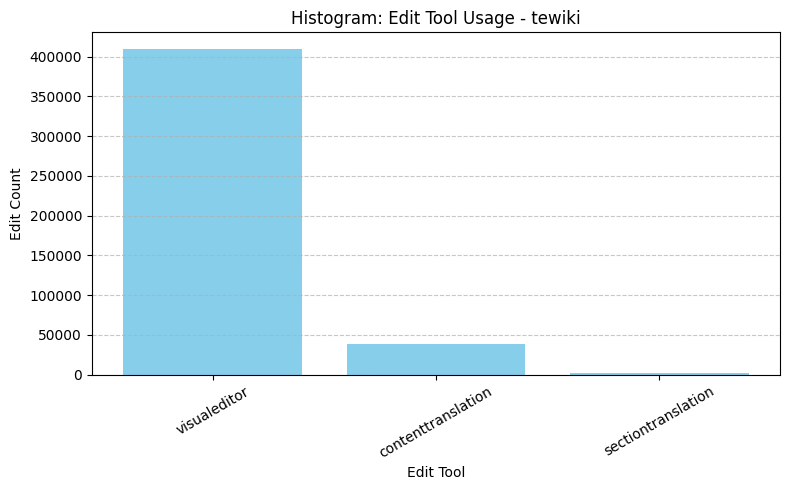

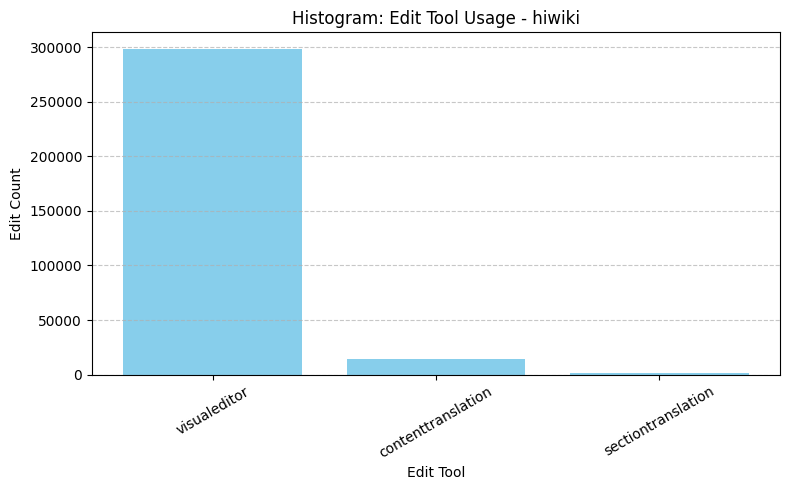

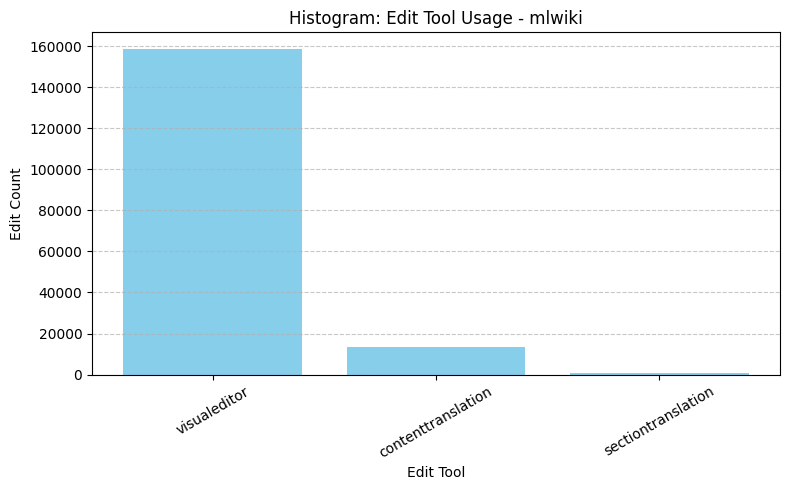

In [47]:
for wiki in wikis:
    print(f"🔄 Querying {wiki}...")
    output = connect_and_query(wiki, query)
    if output:
        df = pd.DataFrame(output, columns=['edit_tool', 'edit_count'])
        df['wiki'] = wiki
        all_data.append(df)
    else:
        print(f"⚠️ No data from {wiki}")

# Combine all wiki data
if all_data:
    combined_df = pd.concat(all_data, ignore_index=True)

    # Plot histogram for each wiki
    for wiki in wikis:
        temp = combined_df[combined_df['wiki'] == wiki]
        plt.figure(figsize=(8, 5))
        plt.bar(temp['edit_tool'], temp['edit_count'], color='skyblue')
        plt.title(f'Histogram: Edit Tool Usage - {wiki}')
        plt.xlabel('Edit Tool')
        plt.ylabel('Edit Count')
        plt.xticks(rotation=30)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
else:
    print("❌ No data available to plot.")